In [143]:
import numpy as np
import matplotlib.pyplot as plt

In [145]:
gamma = 5
noise_power_dBm = -90
noise_power_linear = 10 ** (noise_power_dBm / 10)  # Convert dBm to linear units

In [147]:

def generate_random_coordinates_within_circle(center, radius):
    """
    Generate a random point within a circle given its center and radius.
    """
    # Generate an angle and distance from the center
    angle = 2 * np.pi * np.random.rand()
    distance_from_center = radius * np.sqrt(np.random.rand())
    
    x = center[0] + distance_from_center * np.cos(angle)
    y = center[1] + distance_from_center * np.sin(angle)
    
    return np.array([x, y])

def generate_paired_coordinates(num_pairs, region_size=10, radius=0.4):
    """
    Generate transmitter coordinates uniformly in the region and 
    paired receiver coordinates within a circle centered at each transmitter.
    """
    transmitters = np.random.rand(num_pairs, 2) * region_size
    receivers = np.array([generate_random_coordinates_within_circle(tx, radius) for tx in transmitters])
    
    return transmitters, receivers

def calculate_distance_matrix(transmitters, receivers):
    num_transmitters = len(transmitters)
    num_receivers = len(receivers)
    distances = np.zeros((num_transmitters, num_receivers))
    
    for i in range(num_transmitters):
        for j in range(num_receivers):
            x1, y1 = transmitters[i]
            x2, y2 = receivers[j]
            distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            distances[i][j] = distance
    
    return distances

def calculate_link_gain_matrix(distances):
    return 1 / (distances ** 2)

def reaction_function(powers, link_gains, tx_idx):
    """
    Calculate new power for the transmitter tx_idx based on reaction function.
    """
    interference = np.dot(link_gains[:, tx_idx], powers) - link_gains[tx_idx, tx_idx] * powers[tx_idx]
    new_power = 1 / link_gains[tx_idx, tx_idx] * gamma * (noise_power_linear + interference)
    return new_power

def compute_sinr(powers, link_gains, noise_power):
    num_receivers = link_gains.shape[1]
    sinrs = np.zeros(num_receivers)

    for i in range(num_receivers):
        signal = powers[i] * link_gains[i, i]
        interference = np.dot(link_gains[:, i], powers) - signal
        sinrs[i] = signal / (noise_power + interference)
    
    return 10 * np.log10(sinrs)  # Convert SINR to dB

def plot_paired_transmitters_receivers(transmitters, receivers):
    plt.figure(figsize=(10, 10))
    plt.scatter(transmitters[:, 0], transmitters[:, 1], c='red', marker='^', label='Transmitters')
    plt.scatter(receivers[:, 0], receivers[:, 1], c='blue', marker='s', label='Receivers')
    for i in range(len(transmitters)):
        x_values = [transmitters[i][0], receivers[i][0]]
        y_values = [transmitters[i][1], receivers[i][1]]
        plt.plot(x_values, y_values, 'k:', linewidth=0.7)

    plt.xlabel('X-coordinate (km)')
    plt.ylabel('Y-coordinate (km)')
    plt.title('Randomly Paired Transmitters and Receivers in 10 km x 10 km Region')
    plt.xlim(0, 11)
    plt.ylim(0, 11)
    plt.grid(True)
    plt.legend()
    plt.show()

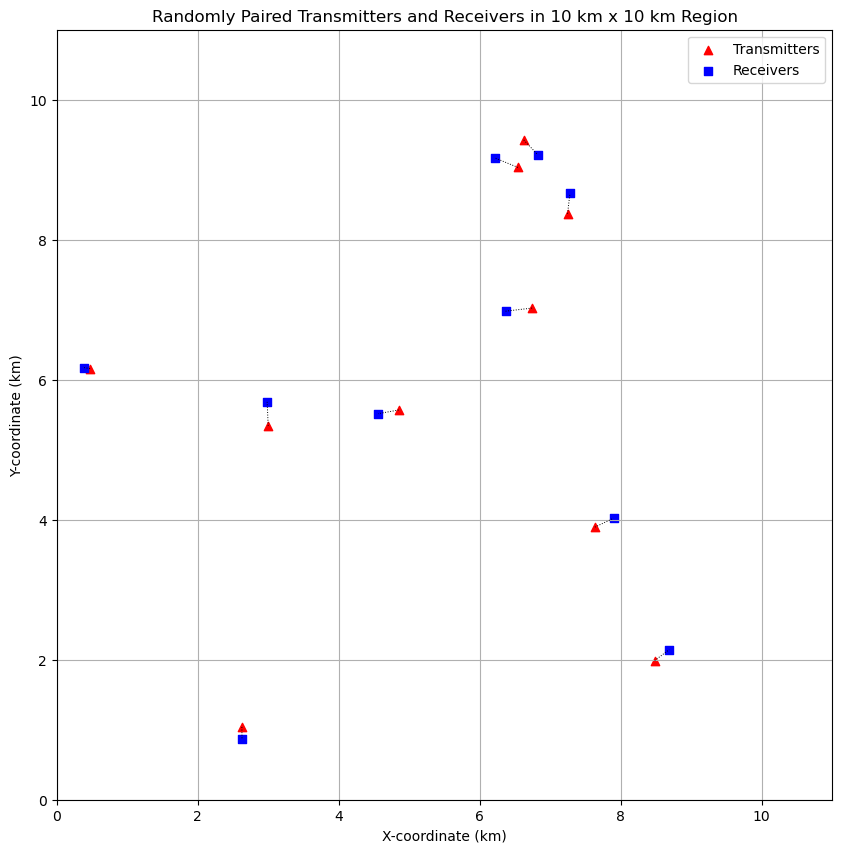

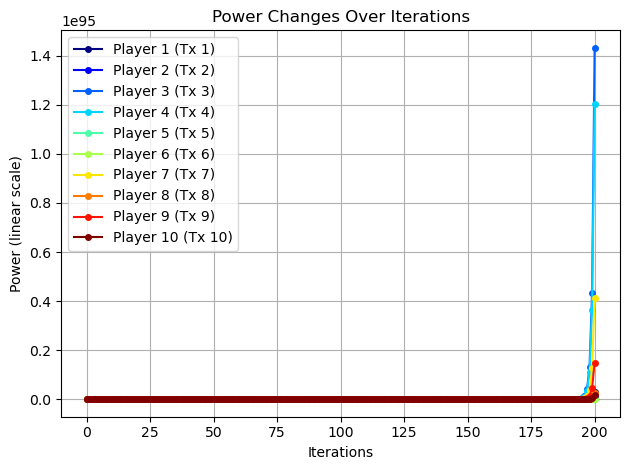

In [149]:
# Number of nodes and region size
num_nodes = 20

# Generate random coordinates for transmitters and receivers

transmitters, receivers = generate_paired_coordinates(num_nodes // 2)

plot_paired_transmitters_receivers(transmitters, receivers)

# Calculate distance matrix and then link gain matrix
distances = calculate_distance_matrix(transmitters, receivers)
link_gains = calculate_link_gain_matrix(distances)

# Initialize powers for each transmitter randomly between 1e-3 and 3e-3 (linear scale for 1 to 5 dBm)
#powers = np.zeros(len(transmitters))
powers = np.random.uniform(1e-9, 3e-9, len(transmitters))
initial_powers = powers
total_power_history = []

# Initial SINRs
initial_sinrs = compute_sinr(initial_powers, link_gains, noise_power_linear)


# Iterative update of powers until convergence
convergence_threshold = 1e-6
max_iterations = 200
iteration = 0

# Lists to track power values for player 1 and 2
power_histories = np.zeros((len(transmitters), max_iterations + 1))  

while iteration < max_iterations:
    new_powers = np.array([reaction_function(powers, link_gains, i) for i in range(len(transmitters))])
    difference = np.abs(new_powers - powers)

    # Update power histories for all players
    
    for i in range(len(transmitters)):
        power_histories[i][iteration + 1] = new_powers[i]
   
    powers = new_powers
    total_power_history.append(np.sum(new_powers))
    iteration += 1

colors = plt.cm.jet(np.linspace(0, 1, len(transmitters)))

# Plot the power changes for all players up to the convergence iteration
for i in range(len(transmitters)):
    plt.plot(power_histories[i][:iteration+1], '-o', label=f"Player {i+1} (Tx {i+1})", color=colors[i], markersize=4)

plt.xlabel("Iterations")
plt.ylabel("Power (linear scale)")
plt.legend()
plt.title("Power Changes Over Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()


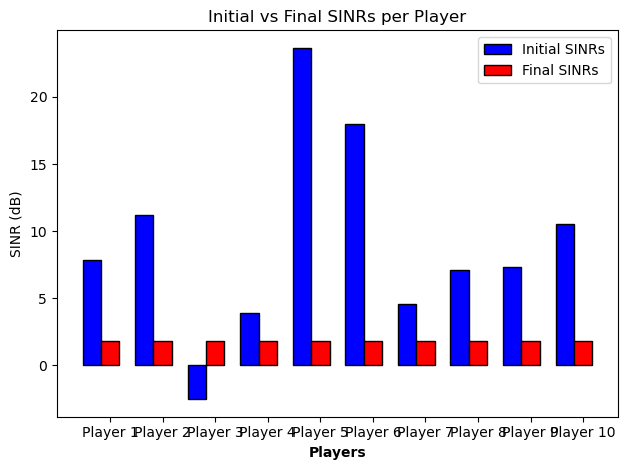

In [151]:
num_players = len(transmitters)
final_sinrs = compute_sinr(powers, link_gains, noise_power_linear)

# Set the width of the bars
bar_width = 0.35

# Set the positions for the bars
r1 = np.arange(num_players)  # positions for initial SINRs
r2 = [x + bar_width for x in r1]  # positions for final SINRs

# Plotting
plt.bar(r1, initial_sinrs, width=bar_width, color='blue', edgecolor='black', label='Initial SINRs')
plt.bar(r2, final_sinrs, width=bar_width, color='red', edgecolor='black', label='Final SINRs')

# Set labels & title
plt.xlabel('Players', fontweight='bold')
plt.xticks([r + bar_width for r in range(num_players)], [f'Player {i+1}' for i in range(num_players)])
plt.ylabel('SINR (dB)')
plt.title('Initial vs Final SINRs per Player')
plt.legend()

# Show the bar chart
plt.tight_layout()
plt.show()

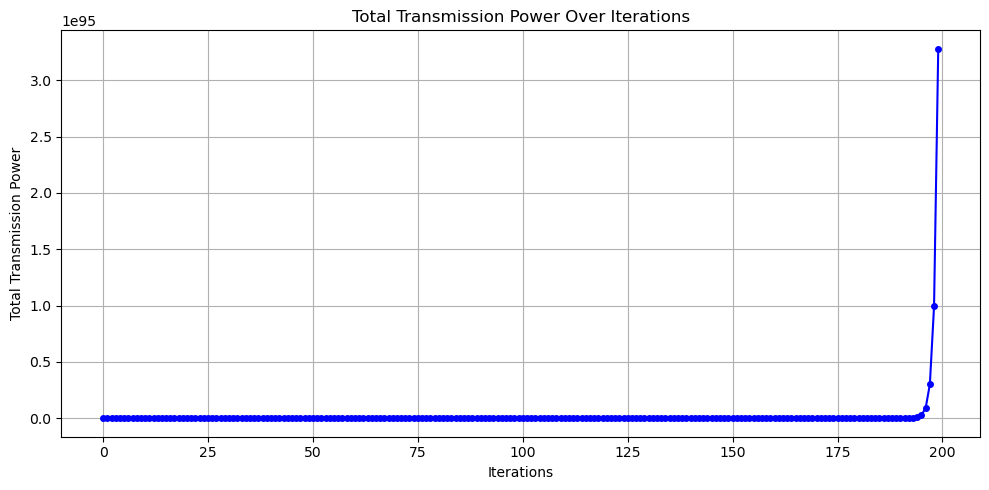

In [153]:
#Total transmission power
plt.figure(figsize=(10, 5))
plt.plot(total_power_history, '-o', color='blue', markersize=4)
plt.xlabel("Iterations")
plt.ylabel("Total Transmission Power")
plt.title("Total Transmission Power Over Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()

In [155]:
print(distances)
np.shape(distances)

[[0.29777977 5.14474166 4.14681926 3.85102137 4.50533402 5.19617559
  3.93374783 1.87057932 2.07206639 3.41912713]
 [5.27733736 0.25908979 7.41410586 7.52661712 9.11475715 5.96267253
  6.77922935 6.6257974  5.42094594 2.11450232]
 [4.42343559 7.56854137 0.28942093 0.48095621 7.03607327 9.44258841
  1.00746981 5.22162817 2.45952411 5.55250693]
 [4.03957416 7.21538126 0.3341533  0.3506038  6.78917501 9.0526513
  0.8259962  4.88792194 2.06074019 5.19176286]
 [4.13777919 9.14906684 7.05016716 6.48874135 0.0851148  5.71097116
  7.25570439 2.55813355 5.95370754 7.7314694 ]
 [4.87543374 6.16611159 9.19094183 8.88737205 5.60080485 0.16783465
  8.93128867 4.65812673 7.02089677 6.05980564]
 [3.92358787 6.3926401  0.94340843 1.29920409 7.20472901 8.80933502
  0.290879   5.04034121 1.64703033 4.39918108]
 [1.56882955 6.52903986 5.44421164 5.00142948 2.74142169 4.48533001
  5.41856303 0.34251318 3.74604647 5.07638625]
 [2.65634864 5.25386219 2.19235368 2.2061598  6.41429401 7.40297982
  1.72265147 

(10, 10)

In [157]:

# Example link gain matrix (can be measured or calculated)
gains = link_gains

# Initialize H matrix
H_matrix = np.zeros(distances.shape)

# Calculate the H matrix using the formula H_ij = gamma * (g_ij / g_ii)
for i in range(distances.shape[0]):
    for j in range(distances.shape[1]):
        if i != j:  # Off-diagonal elements
            H_matrix[i, j] = gamma * (gains[i, j] / gains[i, i])
        else:
            H_matrix[i, j] = 0  # Diagonal elements typically zero in interference models

# Compute the eigenvalues of the H matrix
eigenvalues, _ = np.linalg.eig(H_matrix)

# Get the Perron-Frobenius eigenvalue (the largest real eigenvalue)
perron_frobenius_eigenvalue = np.max(np.real(eigenvalues))

# Display the Perron-Frobenius Eigenvalue and check if it is less than 1
print("Perron-Frobenius Eigenvalue:", perron_frobenius_eigenvalue)

# Check if the largest eigenvalue is less than 1
if perron_frobenius_eigenvalue < 1:
    print("The largest eigenvalue is less than 1.")
else:
    print("The largest eigenvalue is greater than or equal to 1.")


Perron-Frobenius Eigenvalue: 3.3012198728628723
The largest eigenvalue is greater than or equal to 1.


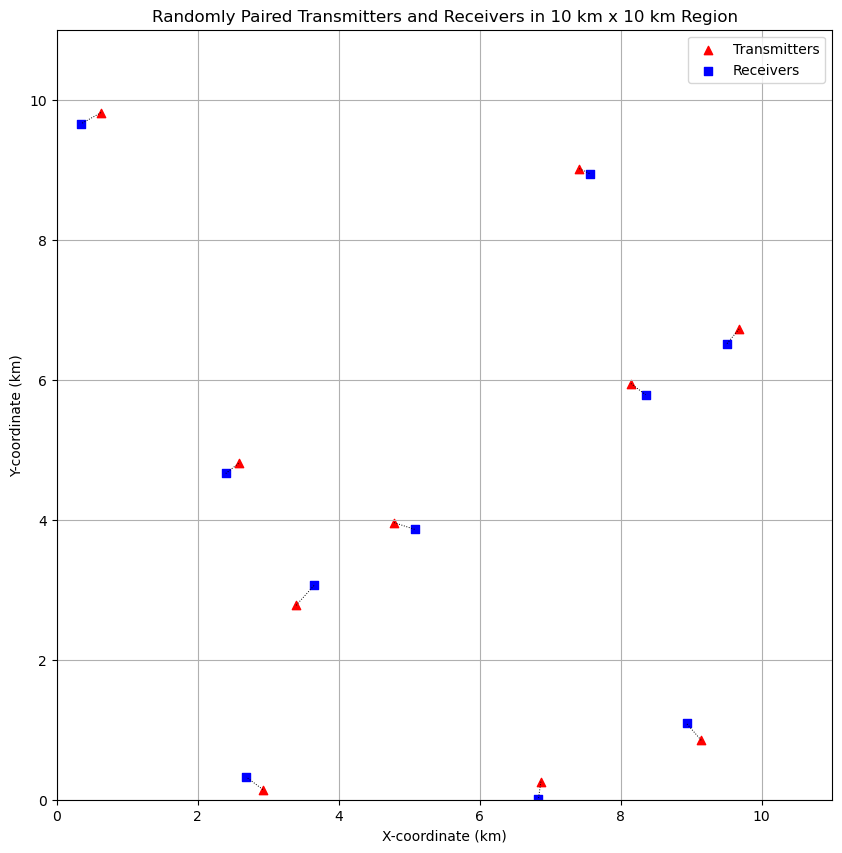

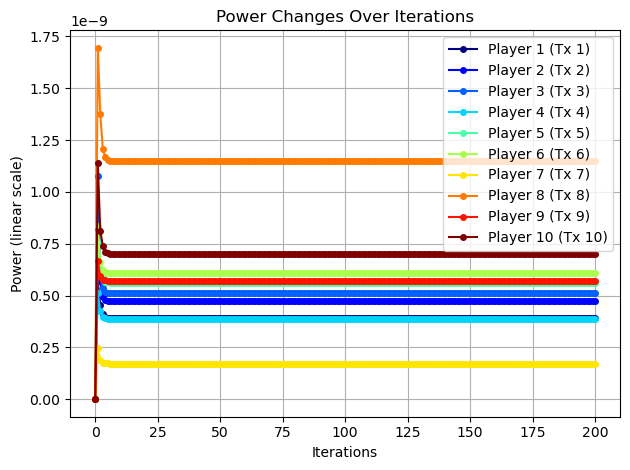

In [159]:
# Number of nodes and region size
num_nodes = 20

# Generate random coordinates for transmitters and receivers

transmitters, receivers = generate_paired_coordinates(num_nodes // 2)

plot_paired_transmitters_receivers(transmitters, receivers)

# Calculate distance matrix and then link gain matrix
distances = calculate_distance_matrix(transmitters, receivers)
link_gains = calculate_link_gain_matrix(distances)

# Initialize powers for each transmitter randomly between 1e-3 and 3e-3 (linear scale for 1 to 5 dBm)
#powers = np.zeros(len(transmitters))
powers = np.random.uniform(1e-9, 3e-9, len(transmitters))
initial_powers = powers
total_power_history = []

# Initial SINRs
initial_sinrs = compute_sinr(initial_powers, link_gains, noise_power_linear)


# Iterative update of powers until convergence
convergence_threshold = 1e-6
max_iterations = 200
iteration = 0

# Lists to track power values for player 1 and 2
power_histories = np.zeros((len(transmitters), max_iterations + 1))  

while iteration < max_iterations:
    new_powers = np.array([reaction_function(powers, link_gains, i) for i in range(len(transmitters))])
    difference = np.abs(new_powers - powers)

    # Update power histories for all players
    
    for i in range(len(transmitters)):
        power_histories[i][iteration + 1] = new_powers[i]
   
    powers = new_powers
    total_power_history.append(np.sum(new_powers))
    iteration += 1

colors = plt.cm.jet(np.linspace(0, 1, len(transmitters)))

# Plot the power changes for all players up to the convergence iteration
for i in range(len(transmitters)):
    plt.plot(power_histories[i][:iteration+1], '-o', label=f"Player {i+1} (Tx {i+1})", color=colors[i], markersize=4)

plt.xlabel("Iterations")
plt.ylabel("Power (linear scale)")
plt.legend()
plt.title("Power Changes Over Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()


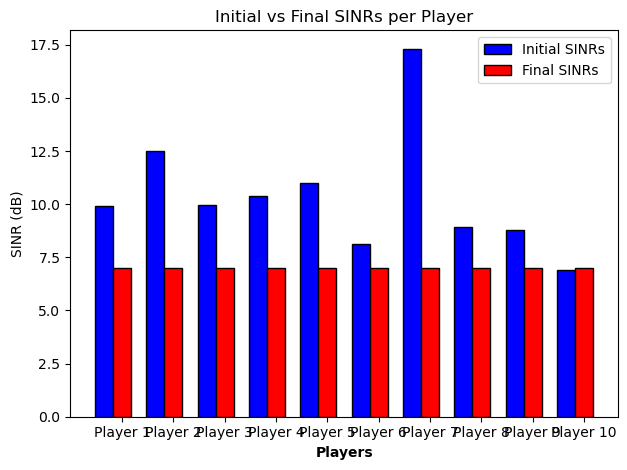

In [161]:
num_players = len(transmitters)
final_sinrs = compute_sinr(powers, link_gains, noise_power_linear)

# Set the width of the bars
bar_width = 0.35

# Set the positions for the bars
r1 = np.arange(num_players)  # positions for initial SINRs
r2 = [x + bar_width for x in r1]  # positions for final SINRs

# Plotting
plt.bar(r1, initial_sinrs, width=bar_width, color='blue', edgecolor='black', label='Initial SINRs')
plt.bar(r2, final_sinrs, width=bar_width, color='red', edgecolor='black', label='Final SINRs')

# Set labels & title
plt.xlabel('Players', fontweight='bold')
plt.xticks([r + bar_width for r in range(num_players)], [f'Player {i+1}' for i in range(num_players)])
plt.ylabel('SINR (dB)')
plt.title('Initial vs Final SINRs per Player')
plt.legend()

# Show the bar chart
plt.tight_layout()
plt.show()

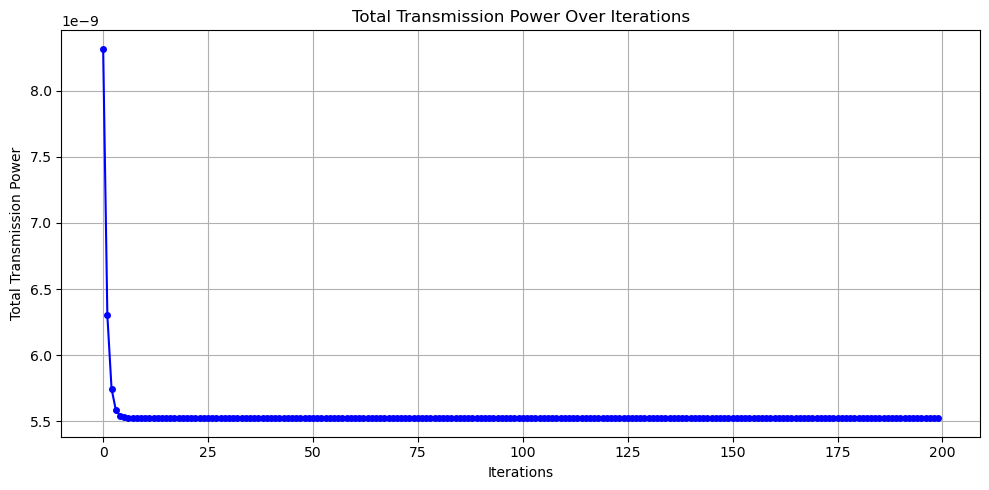

In [163]:
#Total transmission power
plt.figure(figsize=(10, 5))
plt.plot(total_power_history, '-o', color='blue', markersize=4)
plt.xlabel("Iterations")
plt.ylabel("Total Transmission Power")
plt.title("Total Transmission Power Over Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()

In [165]:
# Example link gain matrix (can be measured or calculated)
gains = link_gains

# Initialize H matrix
H_matrix = np.zeros(distances.shape)

# Calculate the H matrix using the formula H_ij = gamma * (g_ij / g_ii)
for i in range(distances.shape[0]):
    for j in range(distances.shape[1]):
        if i != j:  # Off-diagonal elements
            H_matrix[i, j] = gamma * (gains[i, j] / gains[i, i])
        else:
            H_matrix[i, j] = 0  # Diagonal elements typically zero in interference models

# Compute the eigenvalues of the H matrix
eigenvalues, _ = np.linalg.eig(H_matrix)

# Get the Perron-Frobenius eigenvalue (the largest real eigenvalue)
perron_frobenius_eigenvalue = np.max(np.real(eigenvalues))

# Display the Perron-Frobenius Eigenvalue and check if it is less than 1
print("Perron-Frobenius Eigenvalue:", perron_frobenius_eigenvalue)

# Check if the largest eigenvalue is less than 1
if perron_frobenius_eigenvalue < 1:
    print("The largest eigenvalue is less than 1.")
else:
    print("The largest eigenvalue is greater than or equal to 1.")

Perron-Frobenius Eigenvalue: 0.2969828172635345
The largest eigenvalue is less than 1.


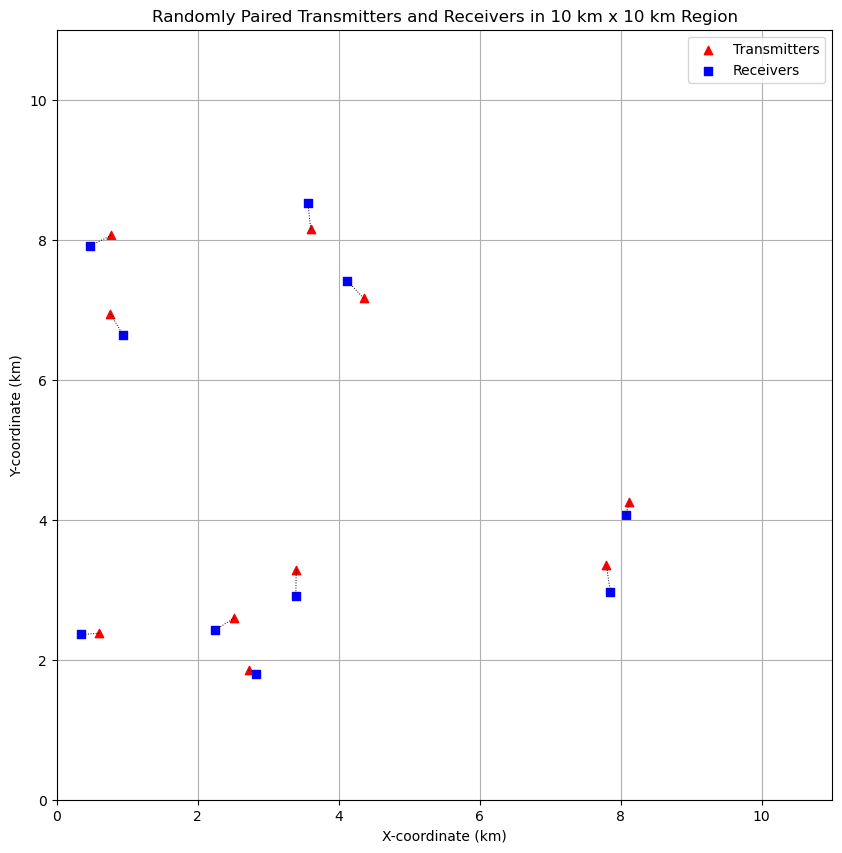

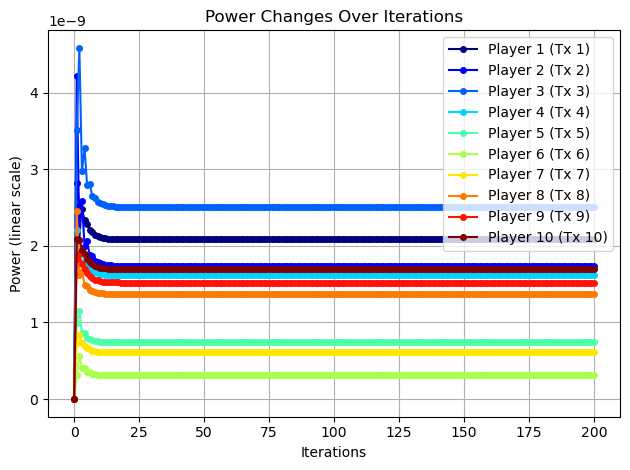

In [167]:
# Number of nodes and region size
num_nodes = 20

# Generate random coordinates for transmitters and receivers

transmitters, receivers = generate_paired_coordinates(num_nodes // 2)

plot_paired_transmitters_receivers(transmitters, receivers)

# Calculate distance matrix and then link gain matrix
distances = calculate_distance_matrix(transmitters, receivers)
link_gains = calculate_link_gain_matrix(distances)

# Initialize powers for each transmitter randomly between 1e-3 and 3e-3 (linear scale for 1 to 5 dBm)
#powers = np.zeros(len(transmitters))
powers = np.random.uniform(1e-9, 3e-9, len(transmitters))
initial_powers = powers
total_power_history = []

# Initial SINRs
initial_sinrs = compute_sinr(initial_powers, link_gains, noise_power_linear)


# Iterative update of powers until convergence
convergence_threshold = 1e-6
max_iterations = 200
iteration = 0

# Lists to track power values for player 1 and 2
power_histories = np.zeros((len(transmitters), max_iterations + 1))  

while iteration < max_iterations:
    new_powers = np.array([reaction_function(powers, link_gains, i) for i in range(len(transmitters))])
    difference = np.abs(new_powers - powers)

    # Update power histories for all players
    
    for i in range(len(transmitters)):
        power_histories[i][iteration + 1] = new_powers[i]
   
    powers = new_powers
    total_power_history.append(np.sum(new_powers))
    iteration += 1

colors = plt.cm.jet(np.linspace(0, 1, len(transmitters)))

# Plot the power changes for all players up to the convergence iteration
for i in range(len(transmitters)):
    plt.plot(power_histories[i][:iteration+1], '-o', label=f"Player {i+1} (Tx {i+1})", color=colors[i], markersize=4)

plt.xlabel("Iterations")
plt.ylabel("Power (linear scale)")
plt.legend()
plt.title("Power Changes Over Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()


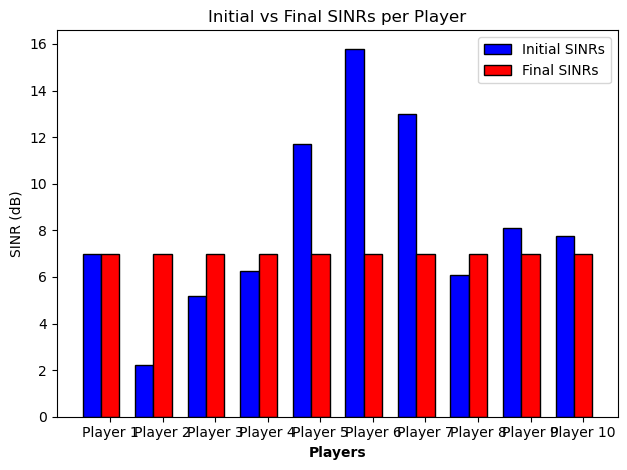

In [169]:
num_players = len(transmitters)
final_sinrs = compute_sinr(powers, link_gains, noise_power_linear)

# Set the width of the bars
bar_width = 0.35

# Set the positions for the bars
r1 = np.arange(num_players)  # positions for initial SINRs
r2 = [x + bar_width for x in r1]  # positions for final SINRs

# Plotting
plt.bar(r1, initial_sinrs, width=bar_width, color='blue', edgecolor='black', label='Initial SINRs')
plt.bar(r2, final_sinrs, width=bar_width, color='red', edgecolor='black', label='Final SINRs')

# Set labels & title
plt.xlabel('Players', fontweight='bold')
plt.xticks([r + bar_width for r in range(num_players)], [f'Player {i+1}' for i in range(num_players)])
plt.ylabel('SINR (dB)')
plt.title('Initial vs Final SINRs per Player')
plt.legend()

# Show the bar chart
plt.tight_layout()
plt.show()

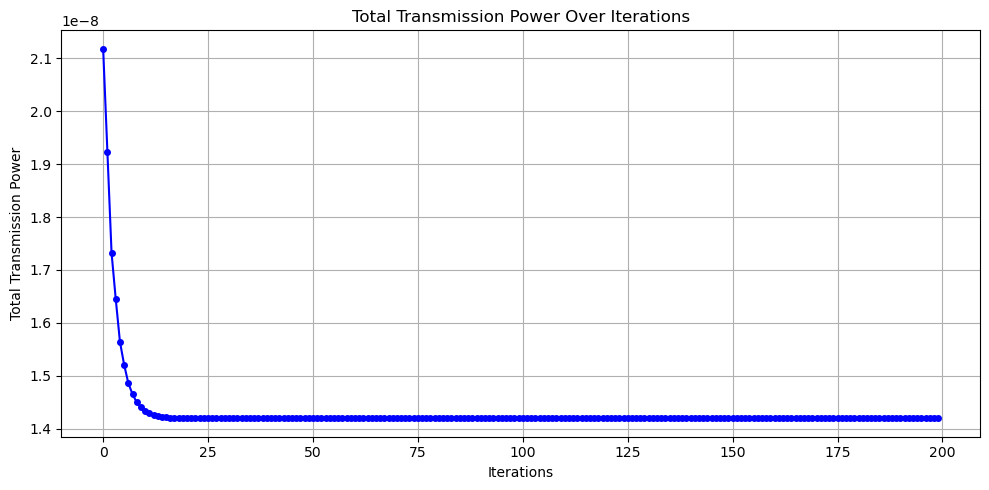

In [171]:
#Total transmission power
plt.figure(figsize=(10, 5))
plt.plot(total_power_history, '-o', color='blue', markersize=4)
plt.xlabel("Iterations")
plt.ylabel("Total Transmission Power")
plt.title("Total Transmission Power Over Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()

In [173]:
# compute matrix of H and find out largest eigen value if it is less than 1 then correlate between 

In [175]:
# Example link gain matrix (can be measured or calculated)
gains = link_gains

# Initialize H matrix
H_matrix = np.zeros(distances.shape)

# Calculate the H matrix using the formula H_ij = gamma * (g_ij / g_ii)
for i in range(distances.shape[0]):
    for j in range(distances.shape[1]):
        if i != j:  # Off-diagonal elements
            H_matrix[i, j] = gamma * (gains[i, j] / gains[i, i])
        else:
            H_matrix[i, j] = 0  # Diagonal elements typically zero in interference models

# Compute the eigenvalues of the H matrix
eigenvalues, _ = np.linalg.eig(H_matrix)

# Get the Perron-Frobenius eigenvalue (the largest real eigenvalue)
perron_frobenius_eigenvalue = np.max(np.real(eigenvalues))

# Display the Perron-Frobenius Eigenvalue and check if it is less than 1
print("Perron-Frobenius Eigenvalue:", perron_frobenius_eigenvalue)

# Check if the largest eigenvalue is less than 1
if perron_frobenius_eigenvalue < 1:
    print("The largest eigenvalue is less than 1.")
else:
    print("The largest eigenvalue is greater than or equal to 1.")

Perron-Frobenius Eigenvalue: 0.6709467342589346
The largest eigenvalue is less than 1.
